## Dev Notebook 2024-11

In [12]:
import neurotorchmz
from neurotorchmz.utils.image import ImgObj
%matplotlib inline

In [2]:
neurotorchmz.Start_Background(neurotorchmz.Edition.NEUROTORCH_DEBUG)

In [3]:
imgObj = neurotorchmz.Get_API().ImageObject

In [32]:
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import numpy as np

In [16]:
diffMax = imgObj.imgDiffView(ImgObj.SPATIAL).Max

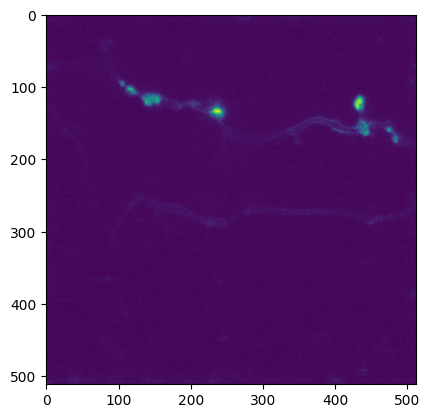

In [17]:
plt.imshow(diffMax)
plt.show()

In [18]:
image_max = ndi.maximum_filter(diffMax, size=20, mode="constant")

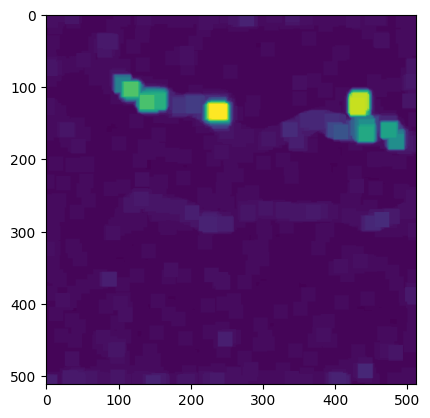

In [19]:
plt.imshow(image_max)

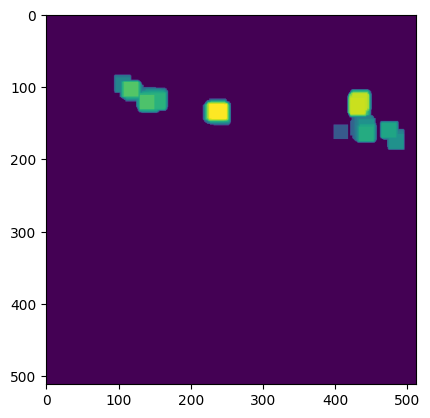

In [37]:
image_max_th = (image_max > 20) * image_max
plt.imshow(image_max_th)

In [47]:
maxima = np.where((image_max_th == diffMax))
print(maxima)

(array([103, 119, 120, 121, 125, 128, 133, 135, 160, 162, 165, 175, 381,
       389, 458]), array([117, 154, 153, 139, 430, 430, 235, 238, 473, 407, 442, 484, 141,
        54, 408]))


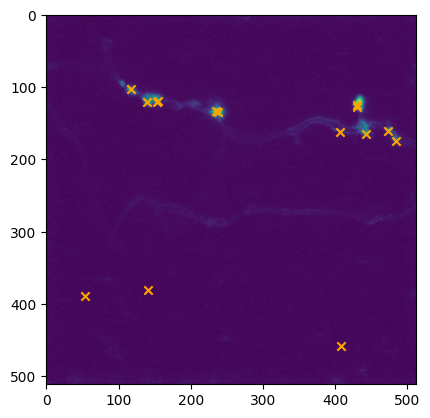

In [49]:
plt.imshow(diffMax)
plt.scatter(maxima[1], maxima[0], marker="x", c="orange")